In [1]:
import sys, os
from pathlib import Path
sys.path.append(str(Path(os.path.dirname(os.path.abspath("__file__"))).parent))

In [2]:
import json
from collections import Counter
import random

import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.manifold import TSNE
import torch
from torch.utils.data import DataLoader
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm import tqdm
import numpy as np

from model import create_net, eval_net
from utils import ImageTransform, print_and_save_result, save_params, save_path_y_ypred
from utils.dataset import CustomImageDataset, make_datapath_list, make_label_list, arrange_data_num_per_label
from utils.parse import argparse_test

In [3]:
def torch_fix_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

torch_fix_seed()

In [4]:
num_per_class = 100
# params_path = "../result/fukui_undersampling/tissue/params.json"
# params_path = "../result/fukui_undersampling/cyclegan_tissue/params.json"
# params_path = "../result/fukui_undersampling/hscyclegan_tissue_lambda_CF_30/params.json"
params_path = "../result/fukui_sscyclegan_CF_rec_30_fake_30_tissue_undersampling/sscyclegan_tissue_CF_rec_30_fake_30/params.json"
with open(params_path, "r") as params_file:
    params = json.load(params_file)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

train_path_list = make_datapath_list(os.path.join("../", params["trainA"]), params["labels"])
train_label_list = make_label_list(train_path_list, params["labels"])
train_path_list, train_label_list = arrange_data_num_per_label("undersampling", train_path_list, train_label_list)
train_path_list = random.sample(train_path_list, num_per_class * len(params["labels"]))
train_label_list = make_label_list(train_path_list, params["labels"])
print("trainのクラスごとのデータ数", sorted(Counter(train_label_list).items()))


test_path_list = make_datapath_list(os.path.join("../", params["test"]), params["labels"])
test_label_list = make_label_list(test_path_list, params["labels"])
# test_path_list, test_label_list = arrange_data_num_per_label("undersampling", test_path_list, test_label_list)
print("testのクラスごとのデータ数", sorted(Counter(test_label_list).items()))

path_list = train_path_list + test_path_list
label_list = train_label_list + test_label_list

使用デバイス： cuda:0
trainのクラスごとのデータ数 [(0, 107), (1, 118), (2, 86), (3, 96), (4, 101), (5, 106), (6, 86)]
testのクラスごとのデータ数 [(2, 271), (3, 86), (4, 303), (6, 147)]


In [6]:
transform = ImageTransform(params)

dataset = CustomImageDataset(path_list, label_list, transform, phase="test")
loader = DataLoader(dataset, batch_size=params["batch_size"], shuffle=False, num_workers=4)

In [7]:
net = create_net(params)
weight_path = os.path.join("../result", params["name"], "weight/weight1.pth")
load_weight = torch.load(weight_path, map_location=device)
net.load_state_dict(load_weight)
extractor = create_feature_extractor(net, ["net.layer4", "net.fc"])

In [8]:
net = net.to(device)
net.eval()
ys = []
ypreds = []
zs = []

for (x, y) in tqdm(loader, total=len(loader)):
    x = x.to(device)
    y = y.to(device)
    with torch.no_grad():
        features = extractor(x)
        ypred = features["net.fc"]
    ys.append(y)
    ypreds.append(features["net.fc"].argmax(1))
    zs.append(features["net.layer4"])

ys = torch.cat(ys).cpu().detach().numpy()
ypreds = torch.cat(ypreds).cpu().detach().numpy()
zs = torch.cat(zs).cpu().detach().numpy()

100%|██████████| 48/48 [00:02<00:00, 18.17it/s]


In [9]:
zs_reshaped = zs.reshape([zs.shape[0], -1])
zs_reshaped.shape

(1507, 25088)

In [10]:
points = TSNE(n_components=2, learning_rate="auto", init="pca", random_state=0).fit_transform(zs_reshaped)

/home/ichiuji/.cache/pypoetry/virtualenvs/thyroid-xS3fZVNL-py3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [11]:
def visualize(points, ys, colors, s, marker, label_prefix):
    point_y_dict = {}
    for point, y in zip(points, ys):
        if point_y_dict.get(y) is None:
            point_y_dict[y] = []
        point_y_dict[y].append(point)

    for y, c in zip(sorted(point_y_dict.keys()), colors):
        p = np.array(point_y_dict[y]).T
        if y == 0:
            label = "正常"
        elif y == 1:
            label = "乳頭癌"
        elif y == 2:
            label = "濾胞癌"
        elif y == 3:
            label = "濾胞型乳頭癌"
        elif y == 4:
            label = "髄様癌"
        elif y == 5:
            label = "低分化癌"
        else:
            label = "未分化癌"
        plt.scatter(p[0], p[1], label=f"{label_prefix}_{label}", s=s, c=c, marker=marker)

In [12]:
def random_sample_point_y(points, ys, sample_num=200):
    indices = range(len(points))
    indices = random.sample(indices, sample_num)
    return points[indices], ys[indices]

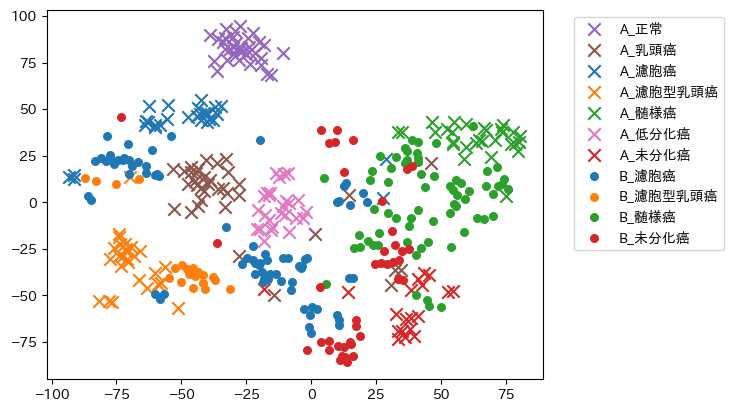

In [13]:
colors_train = ["C4", "C5", "C0", "C1", "C2", "C6", "C3"]
colors_test = ["C0", "C1", "C2", "C3"]

points_train, points_test = points[:num_per_class * len(params["labels"])], points[num_per_class * len(params["labels"]):]
ys_train, ys_test = ys[:num_per_class * len(params["labels"])], ys[num_per_class * len(params["labels"]):]

points_train, ys_train = random_sample_point_y(points_train, ys_train)
points_test, ys_test = random_sample_point_y(points_test, ys_test)

visualize(points_train, ys_train, colors_train, 80, "x", "A")
visualize(points_test, ys_test, colors_test, 30, "o", "B")

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')